Import packages

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

import cv2
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report
from skimage import io
from pandas.core.common import flatten
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import glob
import os
import random
import time

from torch.utils.data import sampler

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
#print(device)

Set up datasets

In [110]:
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for image, ax in zip( images, axes):
        ax.imshow(image.astype('uint8'))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
TRAIN_DIR = 'data\\train'
VAL_DIR = 'data\\val'
TEST_DIR = 'data\\test'

classes = []
train = []
val = []
test = []

for data_path in glob.glob(os.path.join(TRAIN_DIR, '*')):
#     print(data_path)
    cls = data_path.split('\\')[-1]
    imgs = glob.glob(os.path.join(data_path, '*'))
    classes.append(cls)
    train.append(imgs)

train = list(flatten(train))
random.shuffle(train)
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

for data_path in glob.glob(os.path.join(VAL_DIR, '*')):
    imgs = glob.glob(os.path.join(data_path, '*'))
    val.append(imgs)

val = list(flatten(val))
random.shuffle(val)

for data_path in glob.glob(os.path.join(TEST_DIR, '*')):
    imgs = glob.glob(os.path.join(data_path, '*'))
    test.append(imgs)

test = list(flatten(test))

print('class example: ', classes[1])
print('train example: ', train[0])
print('val example: ', val[0])
print('test example: ', test[0])

class example:  PNEUMONIA
train example:  data\train\PNEUMONIA\person1460_virus_2507.jpeg
val example:  data\val\PNEUMONIA\person1951_bacteria_4882.jpeg
test example:  data\test\NORMAL\IM-0001-0001.jpeg


Training Data Balancing

In [37]:
# This function will give a weight to each sample in the data that will be taken into account when using a pytorch sampler, 
#the samples from the minority class will have a larger weight

def make_weights_for_balanced_classes(samples, target, nclasses):                        
    count = [0] * nclasses                                                      
    for item in target:                                                         
        count[item] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(samples)                                              
    for idx, val in enumerate(samples):                                          
        weight[idx] = weight_per_class[target[idx]]                                  
    return weight


In [13]:
count = [0] * 2
print(count)

[0, 0]


In [63]:
class ImageDataset(Dataset):
    def __init__(self, image_paths,transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.image_labels = []
        for filename in image_paths:
                label = filename.split('\\')[-2] 
                label = class_to_idx[label]
                self.image_labels.append(label)

        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image=io.imread(image_filepath)
#         print(image_filepath)
#     The images are already in grayscale so reading the image with imread from the module io will load the image as it is.
#     While reading them with imread from cv2, they will be read as BGR by default. Hence i chose to read them with imread from i0
        
        label = image_filepath.split('\\')[-2] 
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
            return image, label
            
    

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

train_dataset = ImageDataset(train, image_transforms)
val_dataset = ImageDataset(val, image_transforms)
test_dataset = ImageDataset(test, image_transforms)

weights = make_weights_for_balanced_classes(train_dataset.image_paths, train_dataset.image_labels, nclasses=2)  
weights = torch.DoubleTensor(weights)                                       
trainsampler = sampler.WeightedRandomSampler(weights, len(weights))

# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))

## Model definition


In [64]:
class BaselineModel(nn.Module):
    """
    Baseline model built on LeNet architecture.
    """
    def __init__(self, num_classes):
        super().__init__()

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 4, 5)
        self.conv2 = nn.Conv2d(4, 8, 5)

        self.fc1 = nn.Linear(8 * 125 * 125, 125)
        self.fc2 = nn.Linear(125, num_classes)

        self.logsoftmax = nn.LogSoftmax(dim=1)
#         self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # first Conv => ReLU => Pool block
        x = self.pool(self.relu(self.conv1(x)))
        # second Conv => ReLU => Pool block
        x = self.pool(self.relu(self.conv2(x)))

        # flatten
        x = torch.flatten(x, 1)

        # first FC
        x = self.relu(self.fc1(x))
        # second FC
        x = self.fc2(x)

        # class predictions
        output = self.logsoftmax(x)
#         output =self.sigmoid(x)

        return output

model = BaselineModel(len(classes)).to(device)
summary(model, input_size=(3, 512, 512), device=device)
        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 508, 508]             304
              ReLU-2          [-1, 4, 508, 508]               0
         MaxPool2d-3          [-1, 4, 254, 254]               0
            Conv2d-4          [-1, 8, 250, 250]             808
              ReLU-5          [-1, 8, 250, 250]               0
         MaxPool2d-6          [-1, 8, 125, 125]               0
            Linear-7                  [-1, 125]      15,625,125
              ReLU-8                  [-1, 125]               0
            Linear-9                    [-1, 2]             252
       LogSoftmax-10                    [-1, 2]               0
Total params: 15,626,489
Trainable params: 15,626,489
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 3.00
Forward/backward pass size (MB): 26.30
Params size (MB): 59.61
Est

In [70]:
INITIAL_LEARNING_RATE = 1e-3
EPOCHS = 10
BATCH_SIZE = 64

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.NLLLoss()
# loss_func=nn.BCEWithLogitsLoss()

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,sampler=trainsampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_steps = len(train_loader) // BATCH_SIZE
val_steps = len(val_loader) // BATCH_SIZE

In [71]:
start = time.time()

for e in range(EPOCHS):
    print('Epoch {}/{}'.format(e+1, EPOCHS))
    model.train()

    total_train_loss = 0
    total_val_loss = 0

    train_correct = 0
    val_correct = 0

    print('Train:')
    for (x, y) in tqdm(train_loader):
        (x, y) = (x.to(device), y.to(device))

        pred = model(x)
        loss = loss_func(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    print('Val:')
    with torch.no_grad():
        model.eval()

        for (x, y) in tqdm(val_loader):
            (x, y) = (x.to(device), y.to(device))

            pred = model(x)

            total_val_loss += loss_func(pred, y)
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    avg_train_loss = total_train_loss / train_steps
    avg_val_loss = total_val_loss / val_steps

    train_correct = train_correct / len(train_loader.dataset)
    val_correct = val_correct / len(val_loader.dataset)

    history["train_loss"].append(avg_train_loss.cpu().detach().numpy())
    history["train_acc"].append(train_correct)
    history["val_loss"].append(avg_val_loss.cpu().detach().numpy())
    history["val_acc"].append(val_correct)

    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avg_train_loss, train_correct))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avg_val_loss, val_correct))

    torch.save(model, "models/model_epoch_{}.pth".format(e))

end = time.time()

print('Total training time: {:.2f}s'.format(end - start))

Epoch 1/10
Train:


100%|██████████| 82/82 [09:07<00:00,  6.68s/it]


Val:


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Train loss: 25.577896, Train accuracy: 0.8627
Val loss: inf, Val accuracy: 0.9375

Epoch 2/10
Train:


100%|██████████| 82/82 [08:21<00:00,  6.11s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Train loss: 6.147932, Train accuracy: 0.9747
Val loss: inf, Val accuracy: 1.0000

Epoch 3/10
Train:


100%|██████████| 82/82 [07:23<00:00,  5.40s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Train loss: 6.173966, Train accuracy: 0.9726
Val loss: inf, Val accuracy: 0.9375

Epoch 4/10
Train:


100%|██████████| 82/82 [07:29<00:00,  5.48s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Train loss: 3.039671, Train accuracy: 0.9891
Val loss: inf, Val accuracy: 0.9375

Epoch 5/10
Train:


100%|██████████| 82/82 [07:07<00:00,  5.21s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Train loss: 2.068437, Train accuracy: 0.9927
Val loss: inf, Val accuracy: 1.0000

Epoch 6/10
Train:


100%|██████████| 82/82 [07:12<00:00,  5.28s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Train loss: 2.608635, Train accuracy: 0.9912
Val loss: inf, Val accuracy: 0.8750

Epoch 7/10
Train:


100%|██████████| 82/82 [07:16<00:00,  5.33s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Train loss: 1.400590, Train accuracy: 0.9942
Val loss: inf, Val accuracy: 0.9375

Epoch 8/10
Train:


100%|██████████| 82/82 [09:07<00:00,  6.68s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Train loss: 1.085352, Train accuracy: 0.9973
Val loss: inf, Val accuracy: 1.0000

Epoch 9/10
Train:


100%|██████████| 82/82 [08:19<00:00,  6.09s/it]


Val:


100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Train loss: 0.348949, Train accuracy: 0.9992
Val loss: inf, Val accuracy: 0.9375

Epoch 10/10
Train:


100%|██████████| 82/82 [08:42<00:00,  6.38s/it]


Val:


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Train loss: 1.543194, Train accuracy: 0.9941
Val loss: inf, Val accuracy: 0.6875

Total training time: 4828.65s


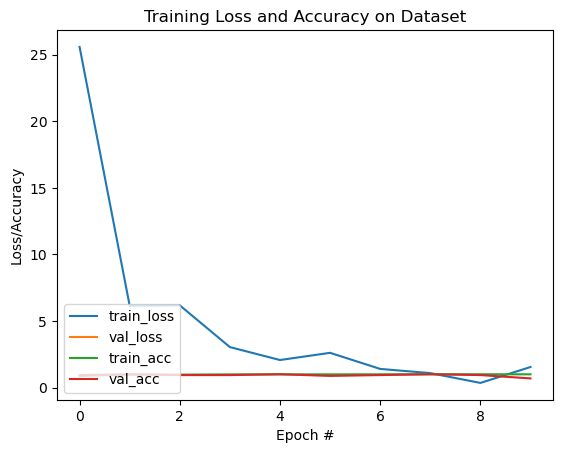

In [72]:
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("output/training.png")

Testing

In [74]:
with torch.no_grad():
    model.eval()

    predictions = []
    targets = []

    print("Test: ")
    for (x, y) in tqdm(test_loader):
        x = x.to(device)

        pred = model(x)
        predictions.extend(pred.argmax(axis=1).cpu().numpy())
        targets.extend(y)

print(classification_report(targets, np.array(predictions), target_names=classes))

Test: 


100%|██████████| 10/10 [00:31<00:00,  3.11s/it]

              precision    recall  f1-score   support

      NORMAL       0.96      0.20      0.33       234
   PNEUMONIA       0.67      0.99      0.80       390

    accuracy                           0.70       624
   macro avg       0.82      0.60      0.57       624
weighted avg       0.78      0.70      0.63       624

